In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.optimizers import Adam
import keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
def make_generator_model(z_dim = 128, n_filter = 64):
    init = RandomNormal(stddev=0.02)
    
    G = Sequential()
    G.add(Dense(2*2*n_filter*8, input_shape=(z_dim,), use_bias=True, kernel_initializer=init))
    
    # 2*2*512
    G.add(Reshape((2,2,n_filter*8)))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 4*4*256
    G.add(Conv2DTranspose(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 8*8*128
    G.add(Conv2DTranspose(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 16*16*64
    G.add(Conv2DTranspose(n_filter, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(LeakyReLU(0.2))
    
    # 32*32*3
    G.add(Conv2DTranspose(3, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    G.add(BatchNormalization())
    G.add(Activation('tanh'))
    
    print('Build Generator')
    print(G.summary())
    
    return G

In [ ]:
def make_discriminator_model(input_shape=(32,32,3), n_filter=64):
    init = RandomNormal(stddev=0.02)
    
    D = Sequential()
    
    # 16*16*64
    D.add(Conv2D(n_filter, input_shape=input_shape, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(LeakyReLU(0.2))
    
    # 8*8*64
    D.add(Conv2D(n_filter*2, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 4*4*64
    D.add(Conv2D(n_filter*4, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    # 2*2*64
    D.add(Conv2D(n_filter*8, kernel_size=(5,5), strides=2, padding='same', use_bias=True, kernel_initializer=init))
    D.add(BatchNormalization())
    D.add(LeakyReLU(0.2))
    
    D.add(Flatten())
    D.add(Dense(1, kernel_initializer=init))
    D.add(Activation('sigmoid'))
    
    print('Build discriminator')
    print(D.summary())
    
    return D




In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

#discriminator: 32x32x3-->16x16x64-->8x8x128--->8192--->1
#generator: 100-->16384-->8x8x256-->8x8x128-->16x16x64-->32x32x3

In [ ]:
z_dim = 100
img_shape = (32, 32, 3)

discriminator = make_discriminator_model(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

generator = make_generator_model(z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(1e-4))


170498071/170498071 [==============================] - 4s 0us/step
100 [D loss: 0.10005943849682808, acc.: 98.4375%] [G loss: 0.02275286614894867]


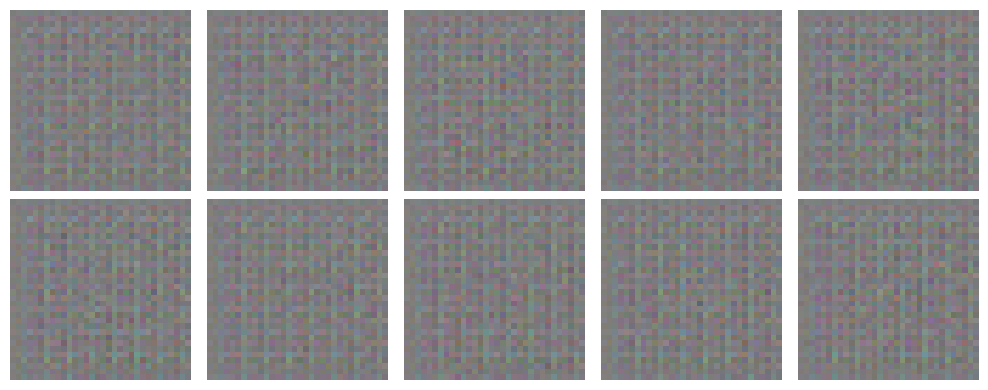

200 [D loss: 0.038522081449627876, acc.: 99.21875%] [G loss: 0.0205269455909729]


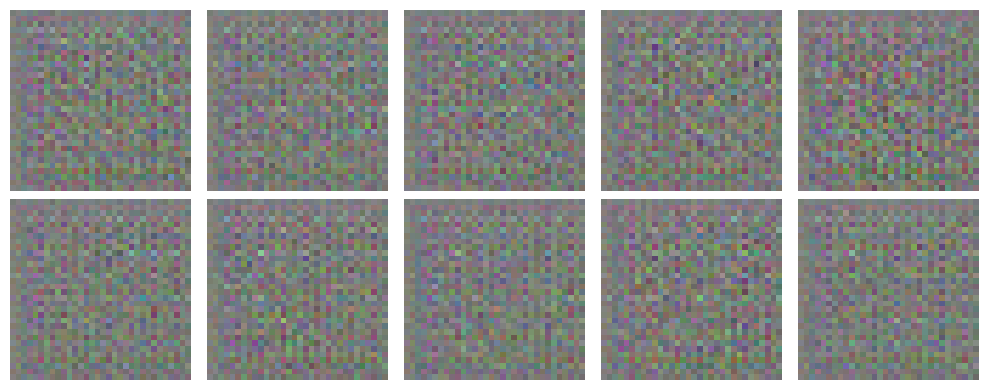

300 [D loss: 0.09299266338348389, acc.: 98.4375%] [G loss: 14.207304000854492]


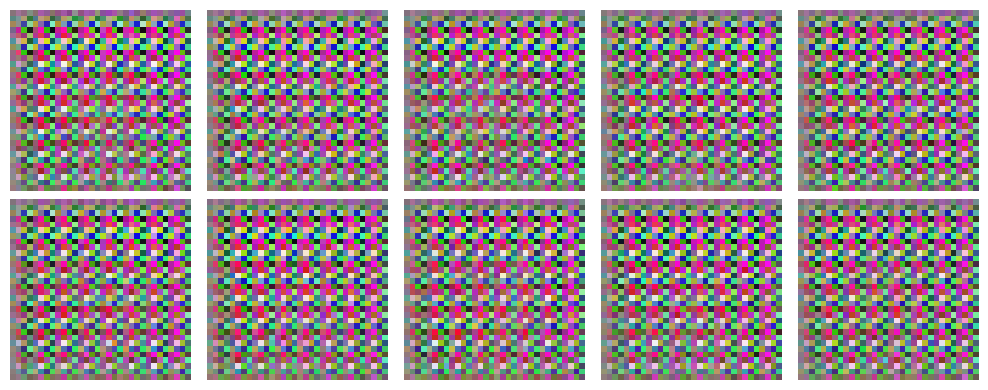

400 [D loss: 0.031847212463617325, acc.: 97.65625%] [G loss: 15.424948692321777]


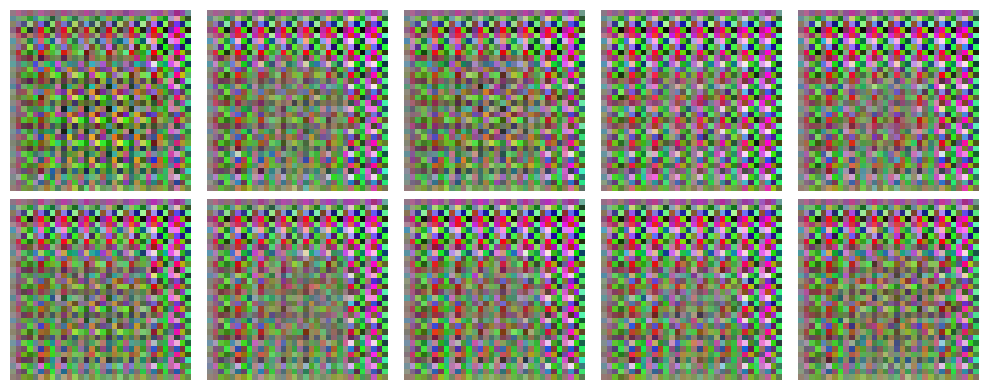

500 [D loss: 0.0, acc.: 100.0%] [G loss: 15.424948692321777]


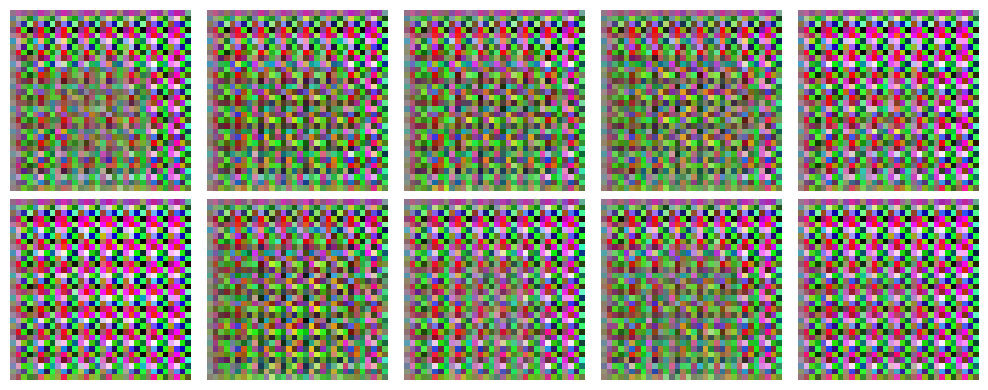

600 [D loss: 0.0009203820955008268, acc.: 100.0%] [G loss: 15.424948692321777]


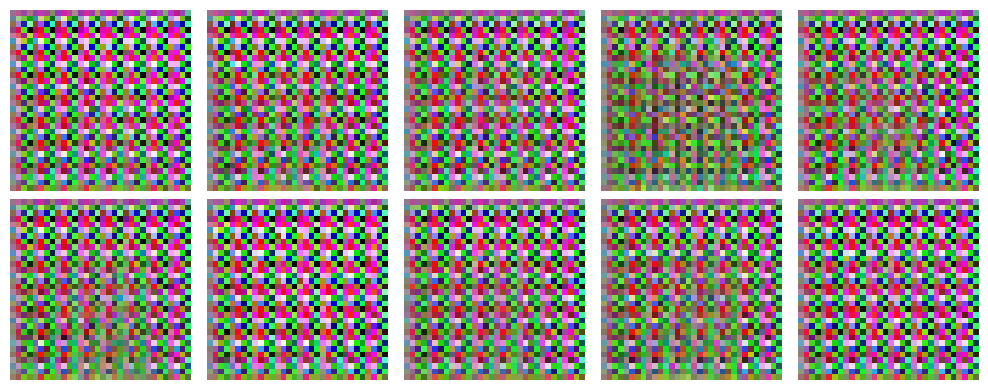

700 [D loss: 0.0, acc.: 100.0%] [G loss: 15.424948692321777]


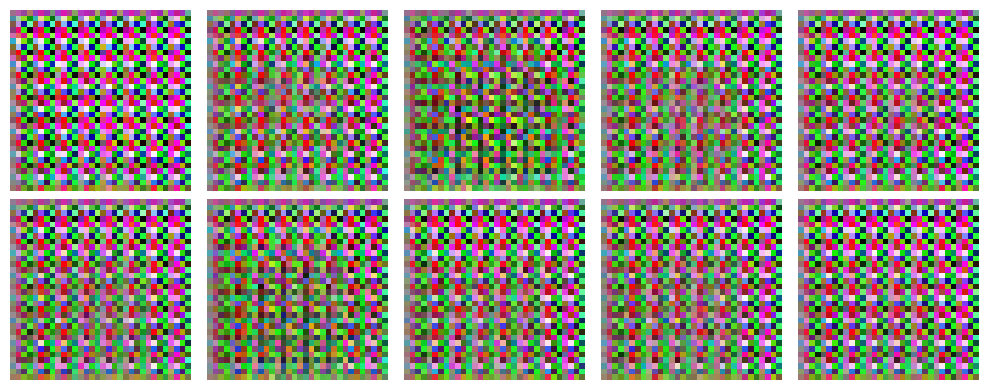

800 [D loss: 0.0031662592664361, acc.: 100.0%] [G loss: 15.424948692321777]


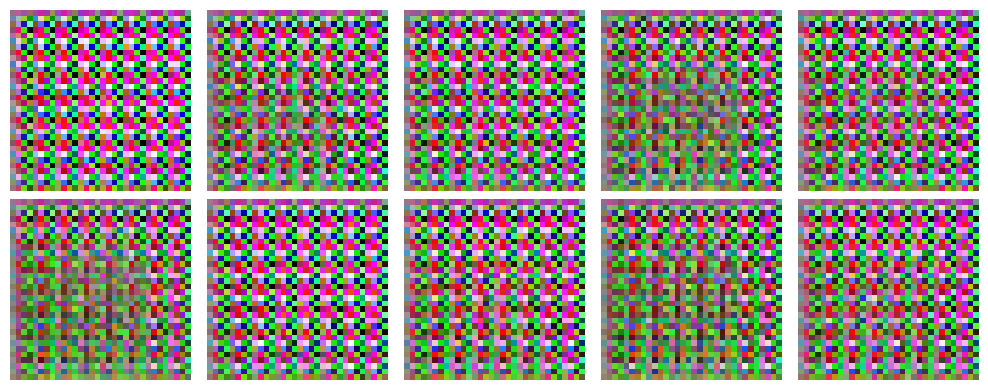

900 [D loss: 0.0, acc.: 100.0%] [G loss: 15.424948692321777]


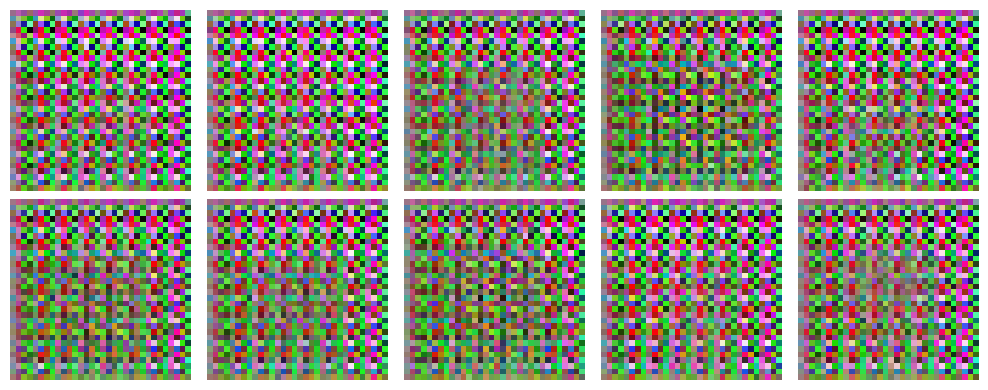

1000 [D loss: 0.0, acc.: 100.0%] [G loss: 15.424948692321777]


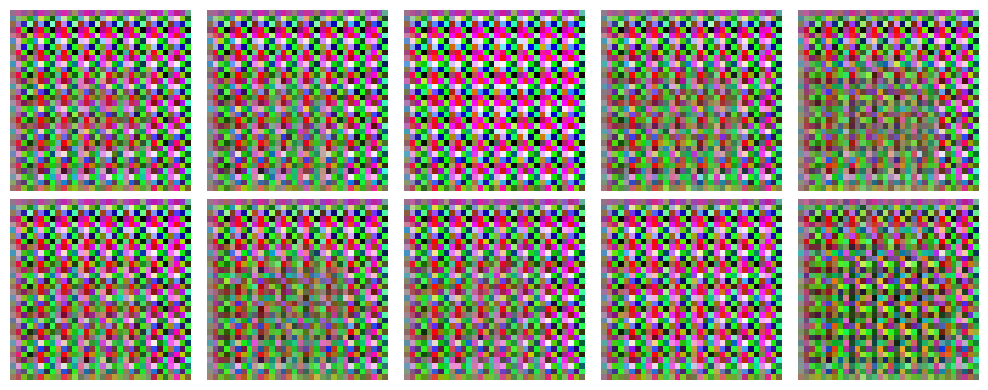

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval, verbose):

    (X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

    # CIFAR-10 labels are:
    # 0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer,
    # 5: dog, 6: frog, 7: horse, 8: ship, 9: truck

    # Extract only the images labeled as 'cat' (label 3)
    #X_train = X_train[y_train.flatten() == 3]

    X_train = X_train / 127.5 - 1.0

    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z, verbose=verbose)

        discriminator.trainable = True

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z, verbose=verbose)

        discriminator.trainable = False

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print(f"{iteration + 1} [D loss: {d_loss}, acc.: {100.0 * accuracy}%] [G loss: {g_loss}]")

            z = np.random.normal(0, 1, (batch_size, z_dim))
            gen_imgs = generator.predict(z, verbose=verbose)

            # Chuyển đổi lại dữ liệu từ phạm vi [-1, 1] về [0, 1]
            gen_imgs_normalized = (gen_imgs + 1.0) / 2.0

            num_images = 10  # Số lượng hình ảnh bạn muốn hiển thị
            plt.figure(figsize=(10, 4))

            for i in range(num_images):
                # Chọn hình ảnh thứ i từ gen_imgs
                plt.subplot(2, 5, i + 1)
                plt.imshow(gen_imgs_normalized[i])
                plt.axis('off')

            plt.tight_layout()
            plt.show()

for epoch in range(2):
    train(10000, 64, 100, 0)


In [ ]:
losses = np.array(losses)
accuracies = np.array(accuracies)

# Vẽ đồ thị mất mát (loss)
plt.figure(figsize=(10, 5))
plt.plot(losses[:, 0], label="Discriminator Loss")
plt.plot(losses[:, 1], label="Generator Loss")
plt.title("Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Vẽ đồ thị độ chính xác (accuracy)
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
